In [3]:
# librerias
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

In [5]:
# carga dataset
file_path = '../DATA/issues_history_ready.csv'
data = pd.read_csv(file_path, encoding='utf-8')
data.head()

,Key,Resolution Time,Blocked,Member Efficiency per ticket,Sprint Overdue,Days to Sprint End,Total Story Points per Sprint and team,Total Story Points per Member per Sprint,Average Team Efficiency per Sprint,Block Rate by Issue Type,...,Sprint_Woof Sprint 5,Team_Team Buzz,Team_Team Howl,Team_Team Meow,Team_Team Panda,Team_Team Quack,Team_Team Roar,Team_Team Woof,Complexity_Low,Complexity_Medium
0,NGP-1035,0.167349,1,0.000033,1.0,0.818182,0.387097,0.333333,0.006379,0.500000,...,0,0,0,0,0,0,0,0,0,1
1,NGP-1036,0.158573,0,0.000055,1.0,0.818182,0.473118,0.454545,0.492863,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,NGP-1037,0.070327,0,0.000124,1.0,0.818182,0.473118,0.454545,0.492863,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,NGP-1042,0.103088,1,0.000053,0.0,0.909091,0.301075,0.181818,0.006957,0.333333,...,0,0,0,0,0,0,0,0,0,1
4,NGP-1043,0.154544,1,0.000035,0.0,0.909091,0.967742,1.000000,0.648653,0.444444,...,0,0,0,0,0,0,0,0,0,1


##### Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)

In [8]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Resolution Time', 'Key'])
y = data['Resolution Time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

## Predicción del Tiempo de Resolución de Incidencias

# Random Forest Regressor

### Entrenamiento simple

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluar el rendimiento
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}")


MAE: 0.01036426464169923, RMSE: 0.03429737415859959


### Validacion cruzada

In [18]:
cv_scores = cross_val_score(rf_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
print("Mean CV MAE:", -cv_scores.mean())

Mean CV MAE: 0.018640640457681303


### Randomized Search

In [46]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de búsqueda de hiperparámetros
param_distributions = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1.0, 'sqrt', 'log2']
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,  # Número de combinaciones aleatorias a probar
    scoring='neg_mean_absolute_error',
    cv=5,  # Validación cruzada de 5 pliegues
    random_state=42,
    n_jobs=-1  # Paralelismo para acelerar el entrenamiento
)

# Entrenar la búsqueda aleatoria
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
best_params = random_search.best_params_
print(f"Mejores Hiper parametros: {best_params}")

Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': 10}
Best MAE: 0.017746591921564504


### Entrenamiento Final

In [73]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    random_state=42,
    n_estimators=500,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=1.0,
    max_depth=None,
    n_jobs = -1
)
rf_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=2, min_samples_split=5, n_estimators=500,
                      n_jobs=-1, random_state=42)

### Validacion

In [75]:
y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred)

print("Random Forest Regressor")
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R² Score: {r2_rf}")

Random Forest Regressor
Mean Absolute Error (MAE): 0.009545405321226974
Mean Squared Error (MSE): 0.0012336088533237575
R² Score: 0.8534653405191435


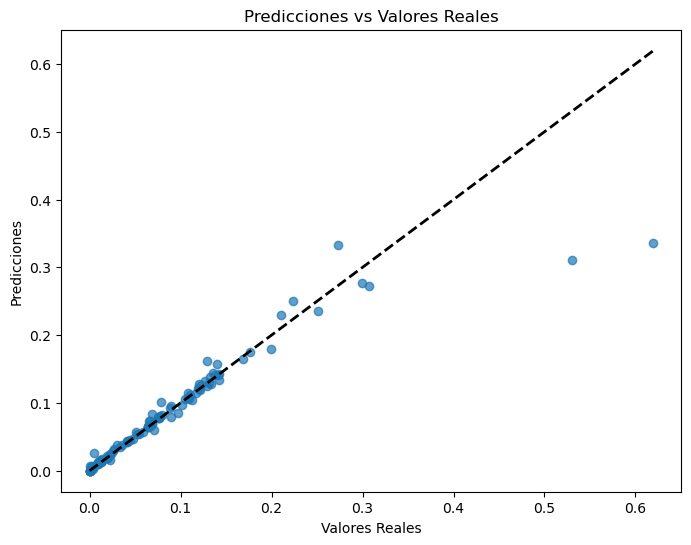

In [89]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

In [91]:
results_rf  = pd.DataFrame({
    'Valores Reales': y_test.values,
    'Valores Predichos': y_pred_rf,
    'Diferencia Absoluta': abs(y_test.values - y_pred_rf),
    'Porcentaje de Acierto': [
        100 - (abs(real - pred) / abs(real) * 100) if real != 0 else None
        for real, pred in zip(y_test.values, y_pred_rf)
    ]
})

results_rf.sort_values(by='Porcentaje de Acierto', ascending=False).head(20)

,Valores Reales,Valores Predichos,Diferencia Absoluta,Porcentaje de Acierto
80,0.068491,0.068453,0.000039,99.943270
67,0.105240,0.105346,0.000106,99.899191
6,0.054042,0.054229,0.000187,99.653895
55,0.141684,0.141152,0.000532,99.624823
44,0.066226,0.066515,0.000290,99.562407
52,0.110919,0.111418,0.000499,99.550551
82,0.107809,0.107269,0.000541,99.498638
14,0.064197,0.063871,0.000326,99.492834
64,0.019469,0.019368,0.000101,99.481354
108,0.119816,0.120462,0.000647,99.460219


### Importancia de las caracteristicas

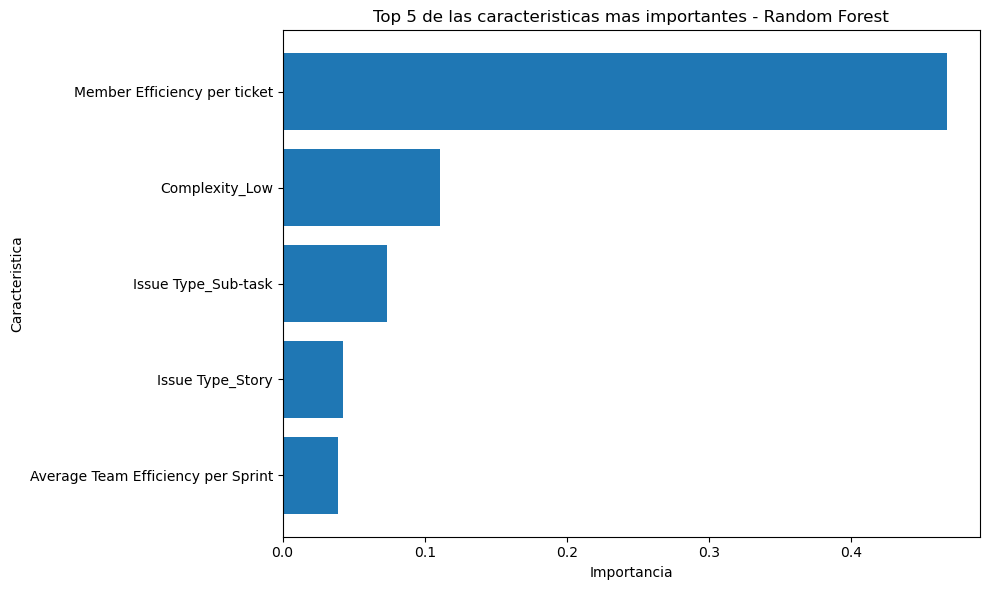

In [93]:
# Obtener las importancias de las características del modelo entrenado
feature_importances = pd.DataFrame({
    'Caracteristica': X_train.columns,
    'Importancia': rf_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

top_features = feature_importances.head(5)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Caracteristica'], top_features['Importancia'], align='center')
plt.xlabel('Importancia')
plt.ylabel('Caracteristica')
plt.title('Top 5 de las caracteristicas mas importantes - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Validacion Cruzada final

In [95]:
cv_scores = cross_val_score(rf_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
print("Mean CV MAE:", -cv_scores.mean())

Mean CV MAE: 0.017713011637736996


# Gradient Boosting Regressor

### Entrenamiento Simple

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
gbr_model.fit(X_train, y_train)
y_pred = gbr_model.predict(X_test)

# Evaluar el rendimiento
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}")


MAE: 0.014265695779551387, RMSE: 0.03902882549840358


### Validacion Cruzada

In [70]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(gbr_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
print("Mean CV MAE:", -cv_scores.mean())

Mean CV MAE: 0.017058556484710587


### Randomized Search

In [72]:
# Definir el espacio de búsqueda
param_distributions = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.5, 0.7, 1.0]
}

# Configurar Randomized Search
random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,  # Número de combinaciones a probar
    scoring='neg_mean_absolute_error',
    cv=5,  # Validación cruzada de 5 pliegues
    random_state=42,
    n_jobs=-1  # Paralelismo
)

# Entrenar Randomized Search
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros y el mejor MAE
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.05}


### Entrenamiento Final

In [55]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(
    subsample=1.0,
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=5,
    learning_rate=0.05,
    random_state=42
)

# Entrenar el modelo con el conjunto de entrenamiento
gbr_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500,
                          random_state=42)

### Validacion

In [57]:
y_pred_gbr = gbr_model.predict(X_test)

mae_gbr = mean_absolute_error(y_test, y_pred)
mse_gbr  = mean_squared_error(y_test, y_pred)
r2_gbr  = r2_score(y_test, y_pred)

print("Gradient Boosting Regressor")
print(f"Mean Absolute Error (MAE): {mae_gbr }")
print(f"Mean Squared Error (MSE): {mse_gbr }")
print(f"R² Score: {r2_gbr }")

Gradient Boosting Regressor
Mean Absolute Error (MAE): 0.00971009077452371
Mean Squared Error (MSE): 0.0012999961502389518
R² Score: 0.8534653405191435


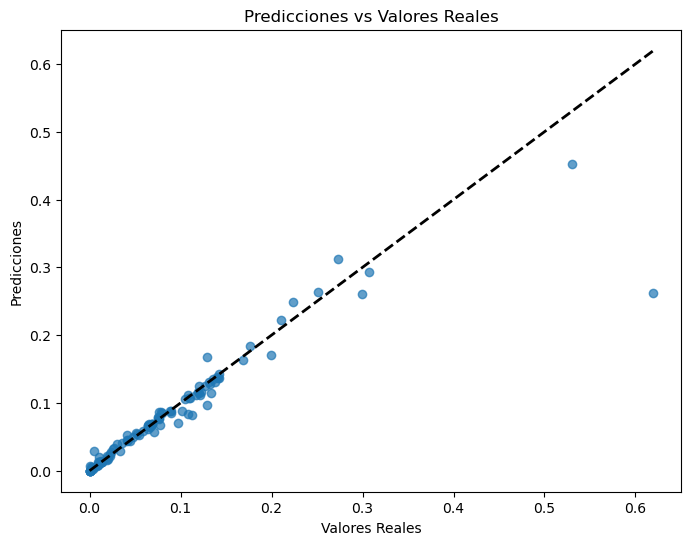

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gbr, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

In [167]:
results_gbr  = pd.DataFrame({
    'Valores Reales': y_test.values,
    'Valores Predichos': y_pred_gbr,
    'Diferencia Absoluta': abs(y_test.values - y_pred_gbr),
    'Porcentaje de Acierto': [
        100 - (abs(real - pred) / abs(real) * 100) if real != 0 else None
        for real, pred in zip(y_test.values, y_pred_gbr)
    ]
})

results_gbr.sort_values(by='Porcentaje de Acierto', ascending=False).head(20)

,Valores Reales,Valores Predichos,Diferencia Absoluta,Porcentaje de Acierto
73,0.142261,0.142237,0.000024,99.983093
33,0.066086,0.066168,0.000082,99.876085
34,0.076285,0.076383,0.000098,99.871697
17,0.012514,0.012534,0.000020,99.839988
80,0.068491,0.068374,0.000117,99.828877
106,0.136092,0.135801,0.000291,99.786252
46,0.011327,0.011357,0.000030,99.731662
56,0.130749,0.130353,0.000397,99.696602
100,0.087948,0.087506,0.000442,99.497317
89,0.068757,0.068371,0.000386,99.439031


### Importancia de las caracteristicas

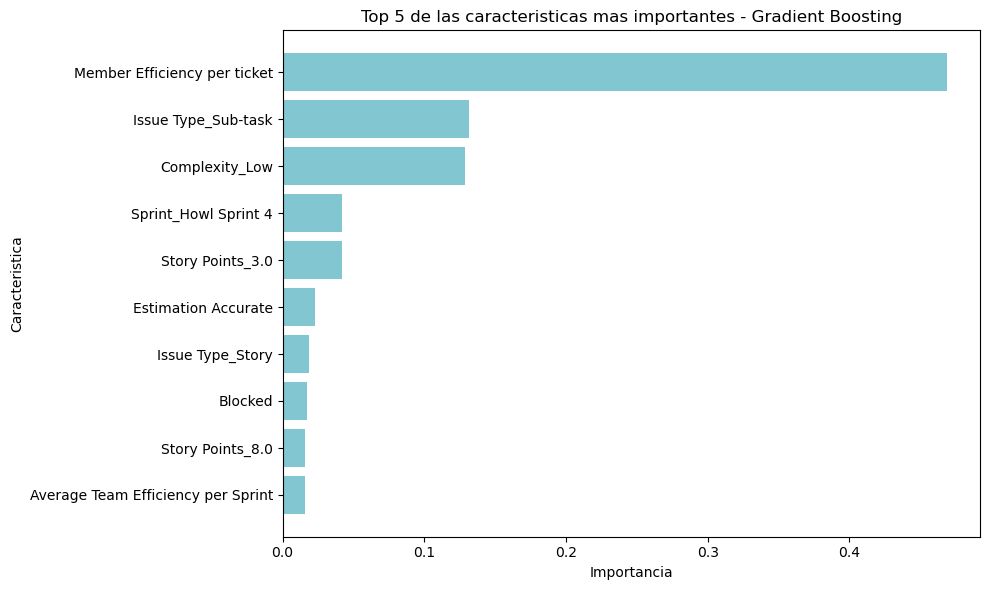

In [204]:
# Obtener la importancia de las características después de entrenar el modelo
feature_importances = pd.DataFrame({
    'Caracteristica': X_train.columns,
    'Importancia': gbr_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Graficar las 10 características más importantes
top_features = feature_importances.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Caracteristica'], top_features['Importancia'], color='#82C6D1')
plt.xlabel('Importancia')
plt.ylabel('Caracteristica')
plt.title('Top 5 de las caracteristicas mas importantes - Gradient Boosting')
plt.gca().invert_yaxis()  # Mostrar la característica más importante en la parte superior
plt.tight_layout()
plt.show()

### Validacion cruzada final

In [97]:
cv_scores = cross_val_score(gbr_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
print("Mean CV MAE:", -cv_scores.mean())

Mean CV MAE: 0.014653467065191179


# XGB Regressor

### Entrenamiento Simple

In [23]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Evaluar el rendimiento
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}")


MAE: 0.014746797007981302, RMSE: 0.05323629770662531


### Validacion Cruzada

In [ ]:
cv_scores = cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
print("Mean CV MAE:", -cv_scores.mean())

### Randomized Search

In [114]:
# Espacio de búsqueda para Randomized Search
param_distributions = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10, None],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 0.1, 0.2, 1],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Configurar Randomized Search CV
random_search_xgb = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,  # Número de combinaciones a probar
    scoring='neg_mean_absolute_error',
    cv=5,  # Validación cruzada de 5 pliegues
    random_state=42,
    n_jobs=-1  # Paralelismo
)

# Entrenar Randomized Search
random_search_xgb.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el mejor MAE
best_params_xgb = random_search_xgb.best_params_

print(f"Best Parameters: {best_params_xgb}")

Best Parameters: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}


### Entrenamiento Final

In [99]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    subsample=1.0,
    reg_lambda=1.5,
    reg_alpha=0,
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    gamma=0,
    colsample_bytree=1.0,
    random_state=42
)

# Entrenar el modelo con el conjunto de entrenamiento
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Validacion

In [101]:
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGB Regressor")
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"R² Score: {r2_xgb}")

XGB Regressor
Mean Absolute Error (MAE): 0.014060011146285734
Mean Squared Error (MSE): 0.0029666006200942184
R² Score: 0.6656068469115848


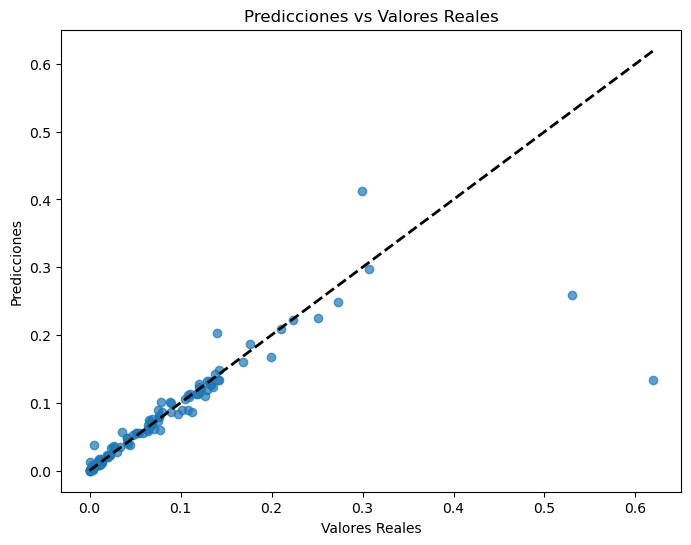

In [103]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

In [105]:
results_xgb = pd.DataFrame({
    'Valores Reales': y_test.values,
    'Valores Predichos': y_pred_xgb,
    'Diferencia Absoluta': abs(y_test.values - y_pred_xgb),
    'Porcentaje de Acierto': [
        100 - (abs(real - pred) / abs(real) * 100) if real != 0 else None
        for real, pred in zip(y_test.values, y_pred_xgb)
    ]
})

results_xgb.sort_values(by='Porcentaje de Acierto', ascending=False).head(20)

,Valores Reales,Valores Predichos,Diferencia Absoluta,Porcentaje de Acierto
67,0.105240,0.105349,0.000109,99.896352
85,0.068939,0.069138,0.000199,99.711344
51,0.223315,0.222608,0.000706,99.683740
101,0.108737,0.109248,0.000511,99.529995
56,0.130749,0.131437,0.000688,99.474021
63,0.022911,0.022782,0.000129,99.438301
44,0.066226,0.065730,0.000495,99.252106
80,0.068491,0.069137,0.000645,99.057550
20,0.122136,0.120958,0.001178,99.035277
107,0.210557,0.208329,0.002228,98.941678


### Importancia de las caracteristicas

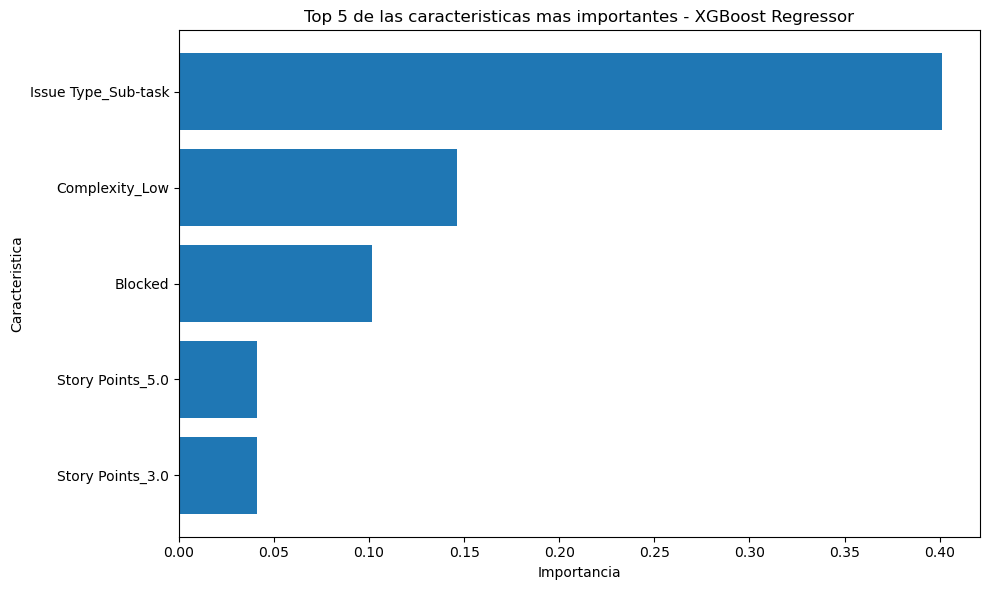

In [126]:
# Obtener la importancia de las características después de entrenar el modelo
feature_importances = pd.DataFrame({
    'Caracteristica': X_train.columns,
    'Importancia': xgb_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Graficar las 10 características más importantes
top_features = feature_importances.head(5)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Caracteristica'], top_features['Importancia'])
plt.xlabel('Importancia')
plt.ylabel('Caracteristica')
plt.title('Top 5 de las caracteristicas mas importantes - XGBoost Regressor')
plt.gca().invert_yaxis()  # Mostrar la característica más importante en la parte superior
plt.tight_layout()
plt.show()

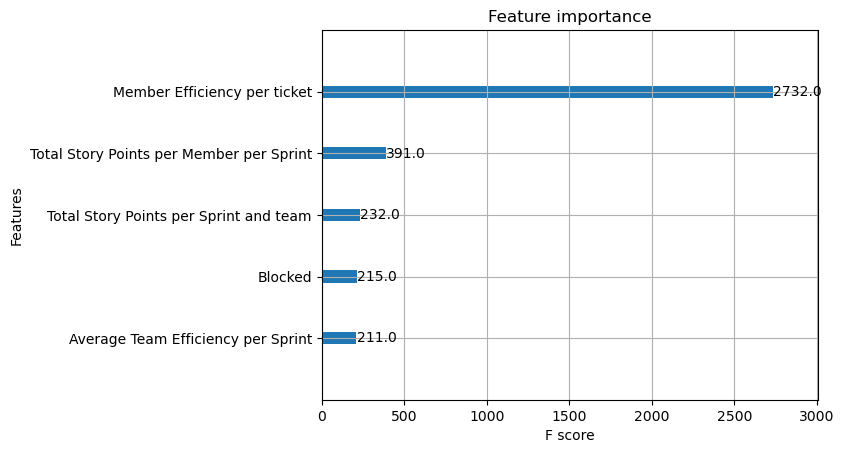

In [128]:
from xgboost import plot_importance
plot_importance(xgb_model, max_num_features=5)
plt.show()

### Validacion cruzada final

In [131]:
cv_scores = cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
print("Mean CV MAE:", -cv_scores.mean())

Mean CV MAE: 0.018399319934724233


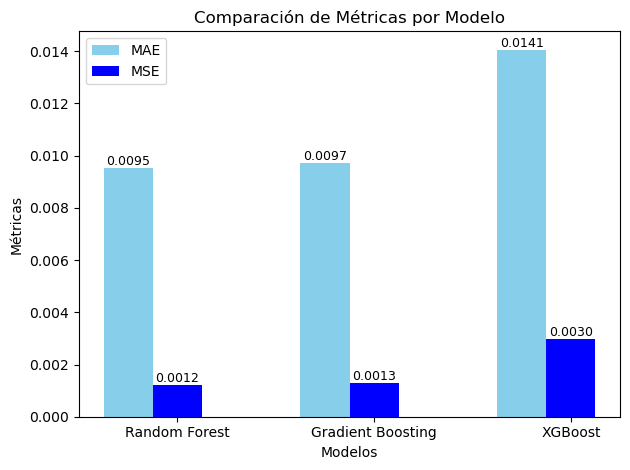

In [154]:
models = ['Random Forest', 'Gradient Boosting', 'XGBoost']
mae = [0.00954, 0.00971, 0.01406]
mse = [0.00123, 0.00130, 0.00297]
r2 = [0.86094, 0.85347, 0.66561]

x = np.arange(len(models))

plt.bar(x, r2, color='#CFB6DC')

for i, val in enumerate(r2):
    plt.text(i, val, f'{val:.4f}', ha='center', va='bottom')

plt.xticks(x, models)
plt.xlabel('Modelos')
plt.ylabel('R')
plt.title('Coeficiente de determinacion')
plt.tight_layout()
plt.show()

x = np.arange(len(models))
width = 0.25

plt.bar(x - width, mae, width, label='MAE', color='skyblue')
plt.bar(x, mse, width, label='MSE', color='blue')

for i, val in enumerate(mae):
    plt.text(i - width, val, f'{val:.4f}', ha='center', va='bottom', fontsize=9)  # MAE
for i, val in enumerate(mse):
    plt.text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=9)  # MSE

plt.xticks(x, models)
plt.xlabel('Modelos')
plt.ylabel('Métricas')
plt.title('Comparación de Métricas por Modelo')
plt.legend()
plt.tight_layout()
plt.show()

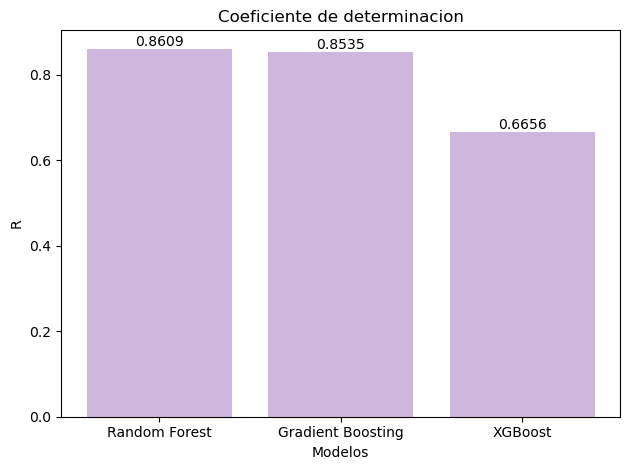

In [138]:
r2 = [0.86094, 0.85347, 0.66561]

x = np.arange(len(models))

plt.bar(x, r2, color='#CFB6DC')

for i, val in enumerate(r2):
    plt.text(i, val, f'{val:.4f}', ha='center', va='bottom')

plt.xticks(x, models)
plt.xlabel('Modelos')
plt.ylabel('R')
plt.title('Coeficiente de determinacion')
plt.tight_layout()
plt.show()

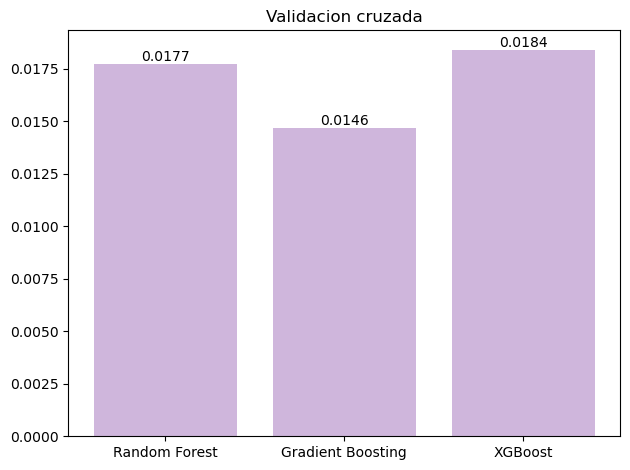

In [146]:
b = [0.01771,0.01465,0.01840]

x = np.arange(len(models))

plt.bar(x, b, color='#CFB6DC')

for i, val in enumerate(b):
    plt.text(i, val, f'{val:.4f}', ha='center', va='bottom')

plt.xticks(x, models)
plt.title('Validacion cruzada')
plt.tight_layout()
plt.show()

# VALIDACION

In [176]:
# carga dataset
file_path = '../DATA/issues_history_eda_fe.csv'
data = pd.read_csv(file_path, encoding='utf-8')
data.head()

,Key,Parent Key,Priority,Story Points,Assignee,Issue Type,Sprint,Team,Resolution Time,Blocked,Member Efficiency per ticket,Sprint Overdue,Days to Sprint End,Complexity,Total Story Points per Sprint and team,Total Story Points per Member per Sprint,Average Team Efficiency per Sprint,Block Rate by Issue Type,Estimation Accurate
0,NGP-1035,NGP-1025,Low,5.0,Juan.hernandez,Story,Team Aether Sprint 9,Team Aether,15.346312,1,0.325811,1,-1,Medium,37.0,23.0,3.188384,0.500000,0
1,NGP-1036,NGP-1070,Low,8.0,Juan.hernandez,Story,Team Aether Sprint 10,Team Aether,14.541528,0,0.550149,1,-1,High,45.0,31.0,241.602579,0.000000,0
2,NGP-1037,NGP-1070,Low,8.0,Juan.hernandez,Story,Team Aether Sprint 10,Team Aether,6.449189,0,1.240466,1,-1,High,45.0,31.0,241.602579,0.000000,1
3,NGP-1042,NGP-1449,Low,5.0,Juan.hernandez,Story,Team Aether Sprint 13,Team Aether,9.453486,1,0.528905,0,0,Medium,29.0,13.0,3.471477,0.333333,0
4,NGP-1043,NGP-1449,Low,5.0,Juan.hernandez,Story,Team Aether Sprint 12,Team Aether,14.172117,1,0.352805,0,0,Medium,91.0,67.0,317.951894,0.444444,0


In [198]:
# Define a function to estimate resolution time in days based on Story Points
def estimate_resolution_time_from_story_points(story_points):
    # Assign resolution time based on the given ranges
    if story_points == 1:
        return 0.5  # Half a day
    elif story_points == 2:
        return 1.5  # 1.5 days
    elif story_points == 3:
        return 2.5  # 2.5 days
    elif story_points == 5:
        return 4  # 4 days
    elif story_points == 8:
        return 5  # 5 days
    elif story_points == 13:
        return 7  # 7 days
    else:
        return 0  # Undefined category for other story points

filtered_data = data.dropna(subset=['Story Points', 'Resolution Time'])

estimated_time = filtered_data['Story Points'].apply(estimate_resolution_time_from_story_points)
actual_time = filtered_data['Resolution Time']

# Calcular MAE base
mae_base = mean_absolute_error(actual_time, estimated_time)
print(f"MAE base (estimaciones manuales): {mae_base}")


MAE base (estimaciones manuales): 6.495037195881937


In [196]:
mae_model = 0.00971  # MAE del modelo
improvement = ((mae_base - mae_model) / mae_base) * 100
print(f"Reducción del MAE: {improvement:.2f}%")

Reducción del MAE: 99.85%
